In [10]:
import pandas as pd

columns_to_read = ["hrhhid", "hrhhid2", "peio1ocd", "ptdtrace", "pulineno", "hrmonth", "gestfips", "pesex", "prtage", "peeduca", "peernlab"]
csv_files = ['../data/cpsb201801.csv', '../data/cpsb201804.csv', '../data/cpsb201808.csv', '../data/cpsb201812.csv', '../data/cpsb201901.csv', '../data/cpsb201904.csv', '../data/cpsb201908.csv', '../data/cpsb201912.csv']


dfs_18 = []
dfs_19 = []

for file in csv_files:
    if '2018' in file:
        df = pd.read_csv(file, usecols=columns_to_read)
        dfs_18.append(df)
    else: 
        df = pd.read_csv(file, usecols=columns_to_read)
        dfs_19.append(df)


combined_df_18 = pd.concat(dfs_18, ignore_index=True)
combined_df_19 = pd.concat(dfs_19, ignore_index=True)

combined_df_18.loc[combined_df_18['peio1ocd'] == '-1', 'pesex']

print(combined_df_18.head())
print(combined_df_19.head())

df_18_filter = combined_df_18[combined_df_18['peio1ocd'] != -1]
df_19_filter = combined_df_19[combined_df_19['peio1ocd'] != -1]



transitions_df = pd.merge(df_18_filter, df_19_filter, on = ['pulineno', 'gestfips', 'pesex','ptdtrace', 'hrhhid', 'hrhhid2'], how = 'inner')

new_job = []
for job1, job2 in zip(transitions_df['peio1ocd_x'], transitions_df['peio1ocd_y']):
    if job1 != job2:
        new_job.append(1)
    else:
        new_job.append(0)

transitions_df['new_job'] = new_job
        
print(f"{sum(transitions_df['new_job'] == 1)/len(transitions_df) * 100}% of respondents reported a job change over the 1 year period")


#all_occupations = set(transitions_df['SOC_18']).union(set(transitions_df['SOC_19']))


#different_rows = different_rows.reset_index(drop = True)

import numpy as np
def format_to_four_digits(value):
    value = int(value)
    num_digits = np.floor(np.log10(value) + 1) if value != 0 else 1  # Handle log10 for zero
    if num_digits == 2 or num_digits == 3:
        return f"{value:04d}"  
    return value

# Apply formatting function to each column
transitions_df['peio1ocd_x'] = transitions_df['peio1ocd_x'].apply(format_to_four_digits)
transitions_df['peio1ocd_y'] = transitions_df['peio1ocd_y'].apply(format_to_four_digits)

#change to string to ensure consistency with other datasets below

transitions_df['peio1ocd_x'] = transitions_df['peio1ocd_x'].astype(str)
transitions_df['peio1ocd_y'] = transitions_df['peio1ocd_y'].astype(str)



cen_soc_10 = pd.read_excel('../data/2010-occ-codes-with-crosswalk-from-2002-2011-1.xlsx', header = 0, skiprows = 4, names = ['', 'occupation', 'census', 'soc'])


#replace X's with the zeros they represent for merging
cen_soc_10['soc'] = cen_soc_10['soc'].astype(str).str.replace(r'XX', '00').str.replace(r'X', '0')

cen_soc_10['census'] = [x.strip() if isinstance(x, str) else x for x in cen_soc_10['census']]
cen_soc_10['soc'] = [x.strip() if isinstance(x, str) else x for x in cen_soc_10['soc']]

#get rid of na values 
cen_soc_10 = cen_soc_10[pd.isna(cen_soc_10['census']) == False]

#get rid of industry headers 
cen_soc_10 = cen_soc_10[~cen_soc_10['census'].str.contains('-', na = False)]

#
cen_soc_10['census'] = cen_soc_10['census'].astype(str)
cen_soc_10['soc'] = cen_soc_10['soc'].astype(str)



#getting rid of census code 9840, military occupations, which is not represented in the SOC crosswalk

codes_to_exclude = ['9840', '9830', '9920']

transitions_df = transitions_df[~transitions_df['peio1ocd_y'].isin(codes_to_exclude) & ~transitions_df['peio1ocd_x'].isin(codes_to_exclude)]

#mapping soc codes onto census codes in the CPS data

transitions_df['SOC_18'] = transitions_df['peio1ocd_x'].map(cen_soc_10.set_index('census')['soc'])
transitions_df['SOC_19'] = transitions_df['peio1ocd_y'].map(cen_soc_10.set_index('census')['soc'])


#no SOC code for census code 9840 for general military occupations so getting rid of these very few transitions. 
#Loosing 134686 - 132700 = 1986 observations. 

#transitions_df = transitions_df[(transitions_df['peio1ocd_x'] != '4700') | (transitions_df['peio1ocd_y'] != '4700')]



wage_df = pd.read_excel('../data/national_M2018_dl.xlsx', usecols = ['OCC_CODE', 'A_MEAN', 'A_MEDIAN'])

#make sure occ codes are clean and of type str
wage_df['OCC_CODE'] = [x.strip() for x in wage_df['OCC_CODE'].astype(str)]

#master set of unique occupations in the transitions data 
occupations = set(transitions_df['SOC_18']).union(set(transitions_df['SOC_19']))

#the occupations which are not represented in the wage data 
[x for x in occupations if x not in list(wage_df['OCC_CODE'])]

#get rid of duplicates which exist for some reason 
wage_df = wage_df[~wage_df.duplicated(keep = 'first')]


#changing SOC codes "13-1021" "13-1022" "13-1023" to "13-1020" to comply with 2017 aggregation as discussed in appendix.

replacement = '13-1020'

codes_to_replace = ['13-1022', '13-1023', '13-1021']

transitions_df['SOC_18'] = [replacement if x in codes_to_replace else x for x in transitions_df['SOC_18']]
transitions_df['SOC_19'] = [replacement if x in codes_to_replace else x for x in transitions_df['SOC_19']]



#mapping income to the original data 

transitions_df['mean_wage_18'] = transitions_df['SOC_18'].map(wage_df.set_index('OCC_CODE')['A_MEAN'])
transitions_df['mean_wage_19'] = transitions_df['SOC_19'].map(wage_df.set_index('OCC_CODE')['A_MEAN'])


#now reading in ONET data 
dwa_df = pd.read_excel("../data/Tasks to DWAs.xlsx", usecols = ['O*NET-SOC Code', 'DWA Title'], dtype={'O*NET-SOC Code': str})
dwa_df.rename(columns={'O*NET-SOC Code': 'onet', 'DWA Title': 'dwa'}, inplace=True)
dwa_df['bool'] = 1

dwa_df['onet'] = [x.strip() for x in dwa_df['onet']]



#creating unique list of soc and onet occupations for crosswalk creation 
soc_codes = set(transitions_df['SOC_18']).union(set(transitions_df['SOC_19']))

onet_codes = set(dwa_df['onet'])




#matching all soc codes which end with 0 or 00 to all onet codes which belong to the same family of occupations

broad_dict = {'soc': [], 'onet': []}

for code in soc_codes:
    if code[4:7] == '000':
        onet = [x for x in onet_codes if x[:4] == code[:4]]
        if not onet:
            broad_dict['soc'].append(code)
            broad_dict['onet'].append('none')
        else:
            broad_dict['soc'].extend([code] * len(onet))
            broad_dict['onet'].extend(onet)
    elif code[5:7] == '00':
        onet = [x for x in onet_codes if x[:5] == code[:5]]
        if not onet:
            broad_dict['soc'].append(code)
            broad_dict['onet'].append('none')
        else:
            broad_dict['soc'].extend([code] * len(onet))
            broad_dict['onet'].extend(onet)
    elif code[-1] == '0':
        onet = [x for x in onet_codes if x[:6] == code[:-1]]
        if not onet:
            broad_dict['soc'].append(code)
            broad_dict['onet'].append('none')
        else:
            broad_dict['soc'].extend([code] * len(onet))
            broad_dict['onet'].extend(onet)
            
            
#matching all soc's which end with 9 to all onet codes which have the same soc base

nine_dict = {'soc': [], 'onet': []}

for code in soc_codes:
    if code[-1] == '9':
        onet = [x for x in list(onet_codes) if x[:-3] == code]
        if not onet:
            nine_dict['soc'].append(code)
            nine_dict['onet'].append('none')
        else: 
            nine_dict['soc'].extend([code] * len(onet))
            nine_dict['onet'].extend(onet)

            
#matching all soc codes which end with .00 to the associated soc 

zero_dict = {'soc': [], 'onet': []}
for code in onet_codes:
    if (code[8:] == '00') & (code[:7] in soc_codes):
        zero_dict['soc'].append(code[:7])
        zero_dict['onet'].append(code)
        
        
cross_dict = {'soc': [], 'onet': []}
dicts = [broad_dict, nine_dict, zero_dict]
for dic in dicts: 
    for key, value in dic.items():
        cross_dict[key].extend(value)
         
crosswalk_df = pd.DataFrame.from_dict(cross_dict)
        

#checking which soc codes are not accounted for in the crosswalk - thee are 16 which all end with 9. 

all_soc = broad_dict['soc'] + nine_dict['soc'] + zero_dict['soc']
all_onet = broad_dict['onet'] + nine_dict['onet'] + zero_dict['onet']
missing_codes = [x for x,y in zip(all_soc, all_onet) if y == 'none']
covered_codes = [x for x,y in zip(all_soc, all_onet) if y != 'none']


transitions_df = transitions_df[(transitions_df['SOC_18'].isin(covered_codes)) & (transitions_df['SOC_19'].isin(covered_codes))]


no_wage = wage_df['OCC_CODE'][wage_df['A_MEAN'] == '*'].tolist()
no_wage.append('45-3011')


transitions_df = transitions_df[~transitions_df['SOC_18'].isin(no_wage) & ~transitions_df['SOC_19'].isin(no_wage)]


onet_nowage = crosswalk_df['onet'][crosswalk_df['soc'].isin(no_wage)].tolist()
dwa_df = dwa_df[~dwa_df['onet'].isin(onet_nowage)]


transitions_df = pd.merge(transitions_df, crosswalk_df, left_on='SOC_19', right_on = 'soc', how ='left', suffixes = ('', '_onet19'))


transitions_df['wage_diff'] = transitions_df['mean_wage_19'].astype(int) - transitions_df['mean_wage_18']



def build_network(adj_df, rca):
        '''
        Intake pandas df of adjacency matrix and outputs symetric normalized covariance matrix.
        elements at index [i,j] are the conditional probability of two items occuring given that one is observed
        
        Parameters
        ----------
        adj_df: pandas dataframe of adjacency matrix

        Returns
        -------
        network: symetric normalized covariance matrix. 
        Elements at index [i,j] are the conditional probability of two items occuring given that one is observed

        '''
        
        adj_m = adj_df.to_numpy()
        

        adj_m = adj_m
        adj_m_t = adj_m.transpose()
        
        
        mat_dot = np.dot(adj_m, adj_m_t)
        degree = np.count_nonzero(adj_m, axis=1) #get number of photos which the article of clothing is styled in


        #normalize matrix
        network = mat_dot / degree 
        network2 = mat_dot / degree
        
        #calculate rca
        denom = degree / sum(degree)
        network = network / denom 
        network2 = network2 / denom 
        
        #filter based on rca 
        network = np.where(network < rca, 0, network)
        network2 = np.where(network2 < rca, 0, network2)
        
        #fill diagonals with zeros so that the network doesn't have any self-loops
        np.fill_diagonal(network, 0)

        #get the indices for the upper and lower traingles of the matrix
        i_lower = np.tril_indices(len(mat_dot))
        i_upper = np.triu_indices(len(mat_dot))

        #make each matrix symmetrical 
        network[i_lower] = network.T[i_lower]
        network2[i_upper] = network2.T[i_upper]

        #We want to conservatively estimate the similarity by taking the lower value
        
        for i in range(len(network)):
            for j in range(len(network)):
                if network2[i][j] < network[i][j]:
                    network[i][j] = network2[i][j]
                else:
                    pass

        return network

dwa_df = dwa_df[dwa_df['onet'].isin(crosswalk_df['onet'])]




adj_df = dwa_df.pivot_table(
    index='dwa', 
    columns='onet',        
    values='bool',       
    fill_value=0          
)

network = build_network(adj_df, rca = 1)


act_dict = {}

for act in adj_df.index:
    onets = dwa_df['onet'][dwa_df['dwa'] == act].drop_duplicates()
    #onets = [x for x in onets if x != 'none']
    socs = crosswalk_df['soc'][crosswalk_df['onet'].isin(onets)]
    mean_wage = wage_df['A_MEAN'][wage_df['OCC_CODE'].isin(socs)].mean()
    act_dict[act] = mean_wage


values = np.array(list(act_dict.values()))

avg_diff = values[:, None] - values



weighted_network = network * avg_diff
weighted_network = np.where(weighted_network == -0.0, 0.0, weighted_network)


#computing the average mobility of each job

new_jobs_df = transitions_df[transitions_df['peio1ocd_x'] != transitions_df['peio1ocd_y']]
job_changes = new_jobs_df['SOC_18'].drop_duplicates()


mobility_dict = {'soc': [], 'moby': [], 'avg_raise': []}

for job in job_changes:
    mean_wage = new_jobs_df['wage_diff'][new_jobs_df['SOC_18'] == job].mean()
    mobility_dict['avg_raise'].append(mean_wage)
    onets = crosswalk_df['onet'][crosswalk_df['soc'] == job].tolist()
    onets = [x for x in onets if x != 'none']
    onet_means = []
    for onet in onets: 
        dwa_list = list(np.where(adj_df[onet] > 0))
        mean_mobility = weighted_network[:, dwa_list].mean(axis = 0).mean()
        onet_means.append(mean_mobility)
    soc_mob = np.mean(onet_means)
    mobility_dict['soc'].append(job)
    mobility_dict['moby'].append(soc_mob)
     





         hrhhid  hrmonth  hrhhid2  gestfips  prtage  pesex  peeduca  ptdtrace  \
0    4795110719        1     6011         1      71      1       42         1   
1    4795110719        1     6011         1      64      2       40         1   
2   71691004941        1     6111         1      72      1       40         1   
3   71691004941        1     6111         1      73      2       40         1   
4  110116792163        1     8011         1      66      1       43         1   

   pulineno  peernlab  peio1ocd  
0         1        -1        -1  
1         2        -1        -1  
2         1        -1      9140  
3         2        -1        -1  
4         1        -1      4920  
         hrhhid  hrmonth  hrhhid2  gestfips  prtage  pesex  peeduca  ptdtrace  \
0    4795110719        1     9011         1      68      1       38         2   
1    4795110719        1     9011         1      64      2       40         2   
2  110116792163        1     8011         1      -1     -1       -

/Users/lorenzogiamartino/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [26]:
moby_mean = np.mean(mobility_dict['moby'])
sd = np.std(mobility_dict['moby'])
        
mobility_dict['z_moby'] = []
for score in mobility_dict['moby']:
    numerator = score - moby_mean 
    mobility_dict['z_moby'].append(numerator/sd)
    

(array([  2.,   4.,  12.,  31., 164., 178.,  28.,   7.,   1.,   2.]),
 array([-4.84480842, -3.86394371, -2.883079  , -1.90221429, -0.92134959,
         0.05951512,  1.04037983,  2.02124454,  3.00210925,  3.98297396,
         4.96383866]),
 <BarContainer object of 10 artists>)

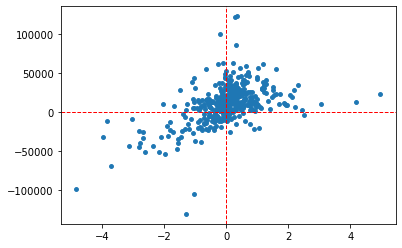

In [31]:
#import matplotlib
from matplotlib import pyplot as plt

plt.scatter(mobility_dict['z_moby'], mobility_dict['avg_raise'], s = 15)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
plt.hist(mobility_dict['z_moby'])

In [18]:
x = pd.Series(mobility_dict['moby'])
y = pd.Series(mobility_dict['avg_raise'])
x.corr(y)




0.5072857927448038